#  Wardrobe Generation with VAE

Using a VAE for generating wardrobe pieces.

## Imports

In [1]:
%matplotlib inline

import matplotlib.animation as animation
import matplotlib.pyplot as plt
import numpy as np
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torchvision.utils as vutils

from IPython.display import HTML
from torch.utils.data import DataLoader, Dataset

## Reproducibility

In [2]:
seed = 24
random.seed(seed)
torch.manual_seed(seed);

## Device Configuration

In [3]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

## Dataset

We will use the well-known [Fashion MNIST](https://github.com/zalandoresearch/fashion-mnist) dataset consisting of 60,000 examples of 28x28 grayscale images of different pieces of clothing.

In [4]:
# We keep the input values normalized between [0, 1] (done by ToTensor()) as suggested in the original VAE paper
dataset = datasets.FashionMNIST(root = './data', train=True, download=True, transform=transforms.ToTensor())
training = DataLoader(dataset, batch_size=128, shuffle=True, num_workers=4)

Let's look at some examples from the training set.

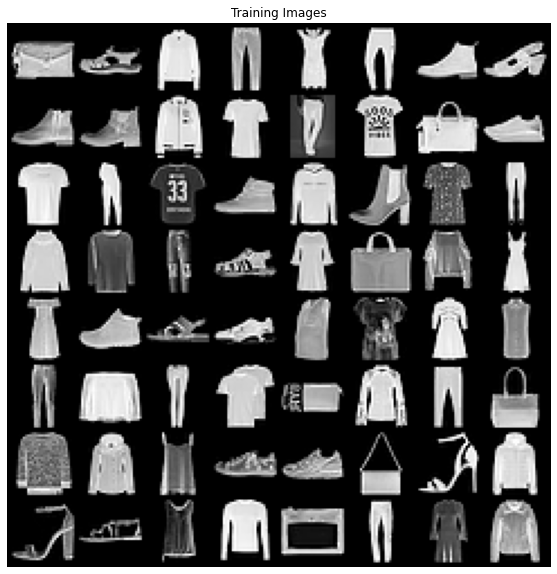

In [5]:
batch = next(iter(training))
plt.figure(figsize=(10, 10))
plt.axis('off')
plt.title('Training Images')
# We need to swap the axes to (height, width, channels) for matplotlib to plot the image correctly
plt.imshow(np.transpose(vutils.make_grid(batch[0][:64], padding=2, normalize=True), (1, 2, 0)));

## Model

We'll use a [VAE](https://arxiv.org/abs/1312.6114) with an architecture that is similar to other ones that have been successfully used in the past with the original MNIST dataset (e.g. PyTorch's official [example](https://github.com/pytorch/examples/blob/master/vae/main.py)).

### Encoder

The encoder is designed to map the input image to a probability distribution from which a latent space vector ($z$) is sampled. This is accomplished as follows:

- An input linear layer with 400 units
- Linear layers for producing the **mean** and the **log of the variance** of the distribution from which $z$ will be sampled (see _Appendix C.2_ of the original VAE paper)

We will map the input image to a latent space vector of size **20**.

### Decoder

The decoder takes in the latent space vector $z$ and reconstructs an image $\hat{x}$ with the objective of $\hat{x} \sim x$. This is done using:

- An input linear layer with 400 units
- An output linear layer that maps back to the image space of 28 x 28 (784)
- A sigmoid output function to return it to the range of the input data, $[0,1]$

In [6]:
latent_size = 20

In [7]:
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()

        self.net = nn.Sequential(
            nn.Linear(in_features=784, out_features=400),
            nn.ReLU(True)
        )

        # Layers for computing the mean and log of the variance vectors of the probability distribution for a latent vector of size `latent_size`
        self.mean = nn.Linear(in_features=400, out_features=latent_size)
        self.log_var = nn.Linear(in_features=400, out_features=latent_size)

    def forward(self, input):
        output = self.net(input)
        mean = self.mean(output)
        log_var = self.log_var(output)
        std = torch.exp(0.5 * log_var)
        # Sample latent vector z
        # We sample e ~ N(0,I) (reparameterization trick!) to approximate the posterior Q(z|x)
        z = mean + std * torch.randn(mean.shape, device=device)

        return mean, log_var, z

In [8]:
class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        
        self.net = nn.Sequential(
            nn.Linear(in_features=latent_size, out_features=400),
            nn.ReLU(True),
            nn.Linear(in_features=400, out_features=784),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.net(input)

In [9]:
# The actual VAE model that combines both encoder and decoder architectures
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()

        self.encoder = Encoder()
        self.decoder = Decoder()

    def forward(self, input):
        # Flatten the images as expected by our encoder
        mean, log_var, z = self.encoder(input.view(-1, 784))
        x_hat = self.decoder(z)

        return mean, log_var, x_hat

    # Sample images given the latent vector z
    def sample(self, z):
        return self.decoder(z)

In [10]:
model = Model()
print(model)

Model(
  (encoder): Encoder(
    (net): Sequential(
      (0): Linear(in_features=784, out_features=400, bias=True)
      (1): ReLU(inplace=True)
    )
    (mean): Linear(in_features=400, out_features=20, bias=True)
    (log_var): Linear(in_features=400, out_features=20, bias=True)
  )
  (decoder): Decoder(
    (net): Sequential(
      (0): Linear(in_features=20, out_features=400, bias=True)
      (1): ReLU(inplace=True)
      (2): Linear(in_features=400, out_features=784, bias=True)
      (3): Sigmoid()
    )
  )
)


## Optimization

VAE's are trained using a loss function that combines a reconstruction error and the KL-Divergence between the approximation of the posterior, $Q(z|x)$ and the real one $P(z|x)$. We will compute each term as follows:

- Reconstruction Error: We will use the MSE between $x$ and $\hat{x}$
- $D_{KL}$: We can compute the divergence analytically as: -$\frac{1}{2} \cdot \sum (1 + \log \sigma^2 - \mu^2 - \sigma^2)$

_Note: See Appendix B of "Auto-encoding Variational Bayes" paper for a full derivation of the analytical KL-Divergence._

For the optimizer, we will use Adam with the default recommended parameters.

In [11]:
def loss_fn(x, x_hat, mean, log_var):
    # We compare the images flattened (x_hat is already flattened by the decoder)
    # We use `reduction=sum` because it allows the model to actually learn; using `reduction=mean` didn't help at all
    # A possible explanation is the relationship between the learning rate and the size of the gradients; `sum` amplifies the gradient which helps
    # when using a small learning rate (0.001 in this case which is the default when using Adam)
    # Playing around with the learning rate (increasing it) when using `reduction=mean` would probably lead to the same results
    # See: https://stackoverflow.com/a/63804415
    reconstruction_loss = F.mse_loss(x.view(-1, 784), x_hat, reduction='sum')
    kl_divergence = -0.5 * torch.sum(1 + log_var - mean ** 2 - torch.exp(log_var))

    return reconstruction_loss + kl_divergence

optimizer = optim.Adam(model.parameters())

## Training

Time to train the model!

In [12]:
# Training configuration
epochs = 20
# Create batch of latent vectors that we will use to visualize the progression of the model
fixed_noise = torch.randn(64, latent_size, device=device)

[0]/[20]	Loss: 5024.0849609375
[1]/[20]	Loss: 3741.51708984375
[2]/[20]	Loss: 3520.15234375
[3]/[20]	Loss: 3418.086669921875
[4]/[20]	Loss: 3361.09326171875
[5]/[20]	Loss: 3313.84228515625
[6]/[20]	Loss: 3278.080078125
[7]/[20]	Loss: 3249.879638671875
[8]/[20]	Loss: 3228.36328125
[9]/[20]	Loss: 3208.236572265625
[10]/[20]	Loss: 3193.637939453125
[11]/[20]	Loss: 3177.9755859375
[12]/[20]	Loss: 3165.183837890625
[13]/[20]	Loss: 3155.622314453125
[14]/[20]	Loss: 3147.202392578125
[15]/[20]	Loss: 3133.346435546875
[16]/[20]	Loss: 3129.23828125
[17]/[20]	Loss: 3119.37255859375
[18]/[20]	Loss: 3114.7314453125
[19]/[20]	Loss: 3106.870361328125


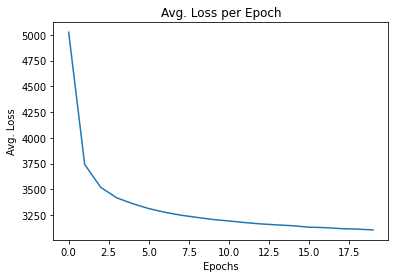

In [13]:
# Main training loop
model = model.to(device)
# The images produced by our model using the fixed noise
sample_images = []
total_losses = []
iters = 0

for epoch in range(epochs):
    losses = []

    for i, data in enumerate(training, 0):
        optimizer.zero_grad()
        x = data[0].to(device)
        
        mean, log_var, x_hat = model(x)
        loss = loss_fn(x, x_hat, mean, log_var)

        loss.backward()
        optimizer.step()
        
        # Detach the loss to avoid saving any more computations on it
        losses.append(loss.detach().cpu().numpy())

        # Check how the model is doing by saving reconstructed output on fixed_noise
        if (iters % 500 == 0) or ((epoch == epochs - 1) and (i == len(training) - 1)):
            with torch.no_grad():
                # Don't forget to call `model.eval()` to set Batch Norm layers to evaluation mode before running inference!
                model.eval()
                fake = model.sample(fixed_noise).detach().cpu()

            # Reshape the flattened image into the original dimensions of the image
            sample_images.append(vutils.make_grid(fake.view(-1, 1, 28, 28), padding=5, normalize=True))

        iters += 1

    total_losses.append(np.mean(losses))
    print(f'[{epoch}]/[{epochs}]\tLoss: {total_losses[-1]}')

# Save the model
torch.save(model.state_dict(), 'model/model.pt')

# Plot the losses per tens of epochs
plt.plot(np.squeeze(total_losses))
plt.ylabel('Avg. Loss')
plt.xlabel('Epochs')
plt.title('Avg. Loss per Epoch')
plt.show()

We can also visualize the progression of the model with an animation of the sample images created from fixed noise.

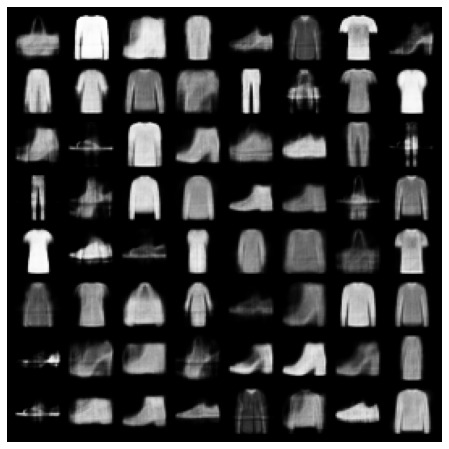

In [14]:
fig = plt.figure(figsize=(8, 8))
plt.axis('off')
ims = [[plt.imshow(np.transpose(i, (1, 2, 0)), animated=True)] for i in sample_images]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

HTML(ani.to_jshtml())

## Testing

Now that we have trained our model, we can use it to generate new pieces of clothing.

In [15]:
# Load the trained model
model = Model()
model.load_state_dict(torch.load('model/model.pt'))
# Always set the mode to `eval` for inference
model.eval()
model = model.to(device)

# Generate a new latent vector
noise = torch.randn(64, latent_size, device=device)
# Pass our fixed noise vector through the trained model
fake = model.sample(noise).detach().cpu()
# Reshape to the original size of the images
fake = fake.view(-1, 1, 28, 28)

Let's look at some real vs fake wardrobe side to side.

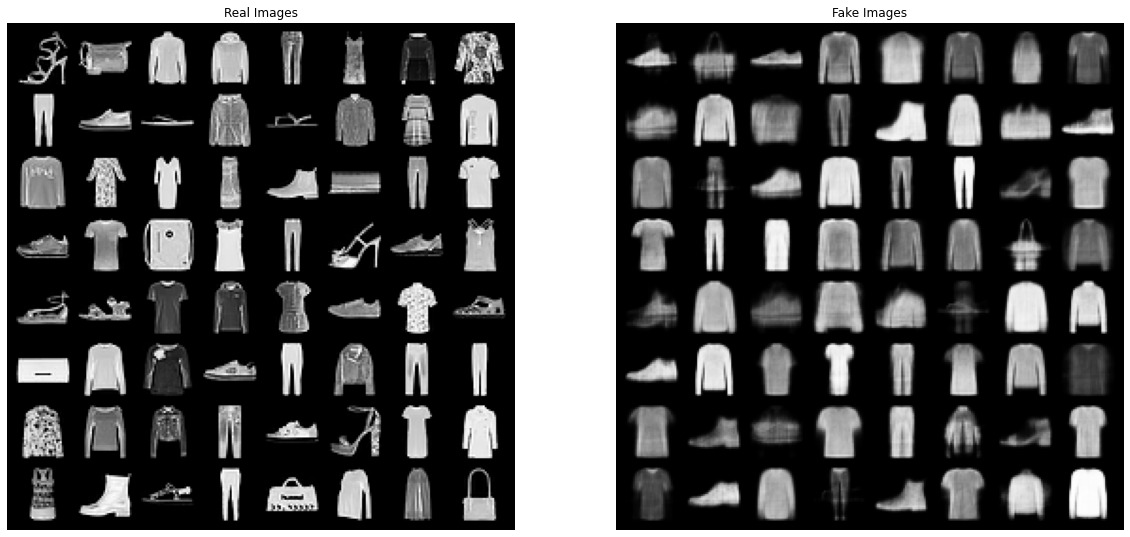

In [16]:
# Grab a batch of real images from the dataloader
real_batch = next(iter(training))

# Plot the real images
plt.figure(figsize=(20, 20))
plt.subplot(1, 2, 1)
plt.axis('off')
plt.title('Real Images')
plt.imshow(np.transpose(vutils.make_grid(real_batch[0][:64], padding=5, normalize=True), (1, 2, 0)))

# Plot the fake images
plt.subplot(1, 2, 2)
plt.axis('off')
plt.title('Fake Images')
plt.imshow(np.transpose(vutils.make_grid(fake, padding=5, normalize=True), (1, 2, 0)))

plt.show()

And here are the fake pieces of clothing by themselves.

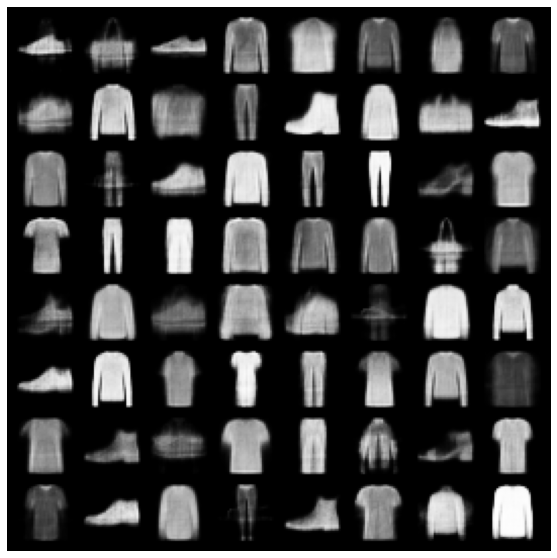

In [17]:
plt.figure(figsize=(10, 10))
plt.axis('off')
plt.imshow(np.transpose(vutils.make_grid(fake, padding=5, normalize=True), (1, 2, 0)))
plt.show()

The model was able to learn really well the features that make up shirts, sweaters, pants and shoes to generate new pieces of clothing. Notice how the generated images look even better than the ones generated by the DCGAN algorithm. However, most of them are blurry. This is a disadvantage of VAE's which is one of the reasons generative models have been dominated by most recent advances in GAN's (e.g. SyleGAN).